In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.applications import MobileNetV2,InceptionV3,VGG16,EfficientNetB0, ConvNeXtTiny
import matplotlib.pyplot as plt
import os

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)


In [3]:
IMAGE_SIZE = 128
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS=30

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE,
)

Found 2143 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
len(dataset)

67

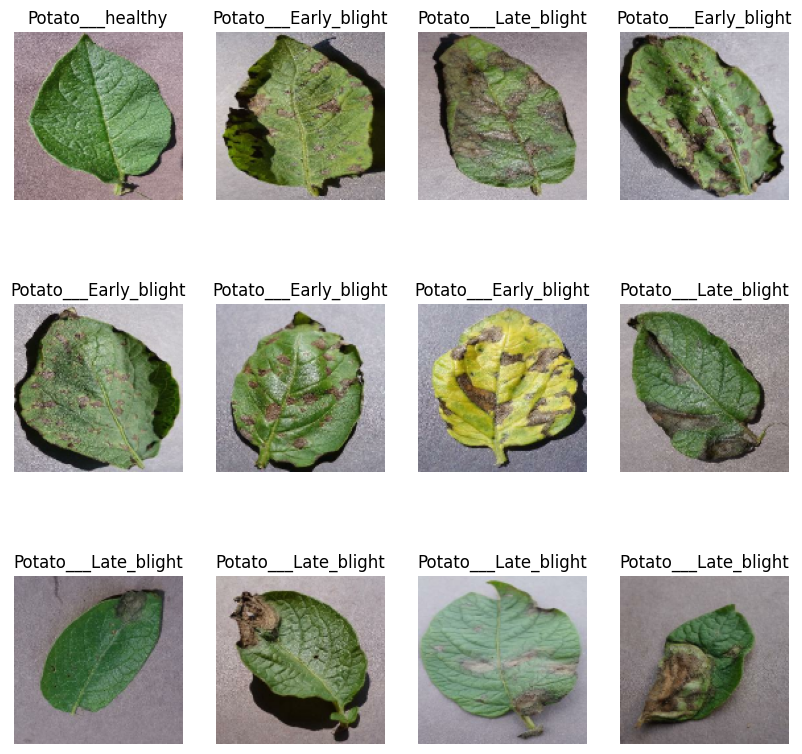

In [7]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))  # Display RGB images
        plt.title(class_names[label_batch[i].numpy()])
        plt.axis("off")

plt.show()

In [8]:
len(dataset)

67

In [9]:
train_size = 0.8
len(dataset)*train_size

53.6

In [10]:
train_ds=dataset.take(53)
len(train_ds)

53

In [11]:
test_ds = dataset.skip(53)
len(test_ds)

14

In [12]:
val_size=0.1
len(dataset)*val_size

6.7

In [13]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [14]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1):
    ds_size = len(ds)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)
    
    return train_ds, val_ds, test_ds


In [16]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds)

53

In [18]:
len(val_ds)

6

In [19]:
len(test_ds)

8

In [20]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
resize_and_rescale=tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [22]:
data_augmentation = tf.keras.Sequential([
 tf.keras.layers.RandomFlip("horizontal_and_vertical"),
 tf.keras.layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])

In [23]:
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, verbose=1)

In [24]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3  # Number of disease categories

# Model Architectures
model = {
    "CNN": models.Sequential([
        resize_and_rescale,
        data_augmentation,
        layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),  # Regularization
        layers.Dense(n_classes, activation='softmax'),
    ]),

    "MobileNetV2": models.Sequential([
        resize_and_rescale,
        MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape),
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(n_classes, activation='softmax')
    ]),

    "InceptionV3": models.Sequential([
        resize_and_rescale,
        InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape),
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(n_classes, activation='softmax')
    ]),

    "VGG16": models.Sequential([
        resize_and_rescale,
        VGG16(include_top=False, weights='imagenet', input_shape=input_shape),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(n_classes, activation='softmax')
    ]),

    "EfficientNetB0": models.Sequential([
        resize_and_rescale,
        EfficientNetB0(include_top=False, weights='imagenet', input_shape=input_shape),
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(n_classes, activation='softmax')
    ]),
}


C:\Users\sivak\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
for model_name, model_obj in model.items():
    if model_name in ["MobileNetV2", "InceptionV3", "VGG16", "EfficientNetB0"]:
        base_model = model_obj.layers[1]  # Second layer is the base model
        base_model.trainable = True  # Enable fine-tuning

for model_name, model_obj in model.items():
    model_obj.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),  # Tuned LR
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )


In [26]:
# Dictionary to store training histories
history_dict = {}

# Train each model separately
for model_name, model_obj in model.items():
    print(f"\n Training Model: {model_name}\n")
    history = model_obj.fit(
        train_ds,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=1,
        validation_data=val_ds,
        callbacks=[lr_schedule]
    )
    # Store history for later comparison
    history_dict[model_name] = history



 Training Model: CNN

Epoch 1/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 19s 277ms/step - accuracy: 0.5782 - loss: 1.0664 - val_accuracy: 0.7604 - val_loss: 0.7303 - learning_rate: 0.0010
Epoch 2/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 274ms/step - accuracy: 0.8447 - loss: 0.4659 - val_accuracy: 0.8125 - val_loss: 0.4731 - learning_rate: 0.0010
Epoch 3/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 268ms/step - accuracy: 0.8679 - loss: 0.3407 - val_accuracy: 0.8698 - val_loss: 0.3687 - learning_rate: 0.0010
Epoch 4/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 259ms/step - accuracy: 0.9018 - loss: 0.2477 - val_accuracy: 0.8125 - val_loss: 0.5640 - learning_rate: 0.0010
Epoch 5/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 256ms/step - accuracy: 0.9026 - loss: 0.2541 - val_accuracy: 0.9115 - val_loss: 0.2905 - learning_rate: 0.0010
Epoch 6/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 13s 248ms/step - accuracy: 0.9288 - loss: 0.2014 - val_accuracy: 0.8594 - val_loss: 0.3696 - learning_rate: 0.0010
Epoch 7/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 13s 252ms/step - accu

In [27]:
test_results = {}
for model_name, model_obj in model.items():
    print(f"\nEvaluating Model: {model_name}\n")
    scores = model_obj.evaluate(test_ds)
    test_results[model_name] = scores
    print(f"{model_name} - Test Accuracy: {scores[1] * 100:.2f}%")



Evaluating Model: CNN

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9747 - loss: 0.0748
CNN - Test Accuracy: 96.08%

Evaluating Model: MobileNetV2

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 249ms/step - accuracy: 0.6927 - loss: 3.6121
MobileNetV2 - Test Accuracy: 70.59%

Evaluating Model: InceptionV3

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 363ms/step - accuracy: 0.9991 - loss: 0.0013    
InceptionV3 - Test Accuracy: 99.61%

Evaluating Model: VGG16

8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.9899 - loss: 0.0560
VGG16 - Test Accuracy: 98.82%

Evaluating Model: EfficientNetB0

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 315ms/step - accuracy: 0.9991 - loss: 0.0015    
EfficientNetB0 - Test Accuracy: 99.61%


In [28]:
model_dir = "models/"
os.makedirs(model_dir, exist_ok=True)
for model_name, model_obj in model.items():
    model_path = f"{model_dir}/{model_name}.keras"
    model_obj.save(model_path)
    print(f"{model_name} saved at {model_path}")

CNN saved at models//CNN.keras
MobileNetV2 saved at models//MobileNetV2.keras
InceptionV3 saved at models//InceptionV3.keras
VGG16 saved at models//VGG16.keras
EfficientNetB0 saved at models//EfficientNetB0.keras


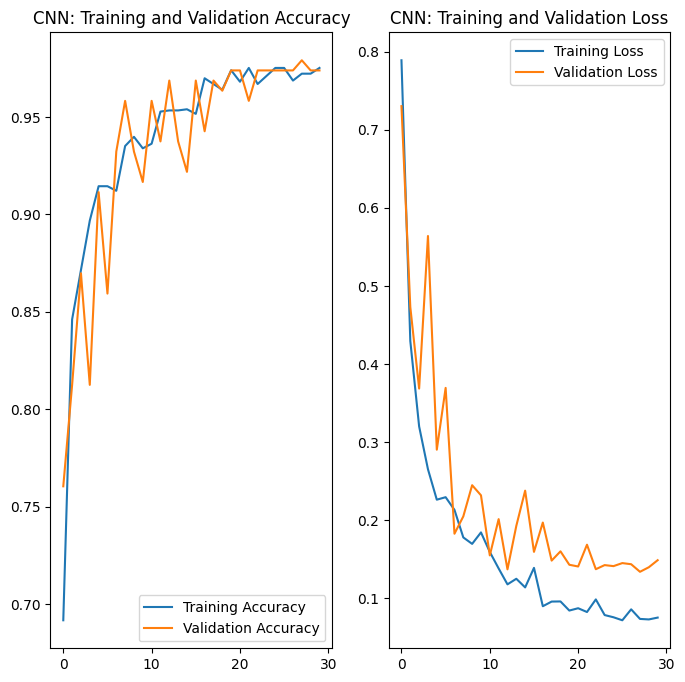

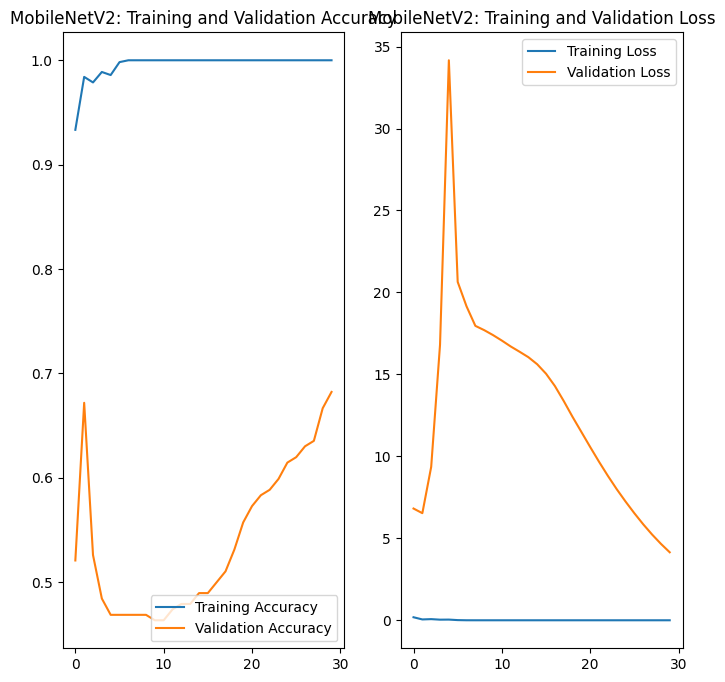

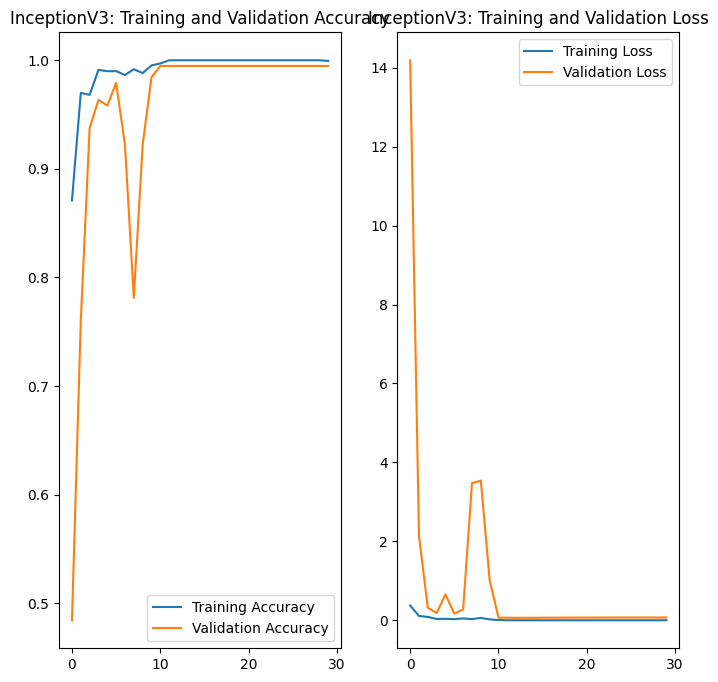

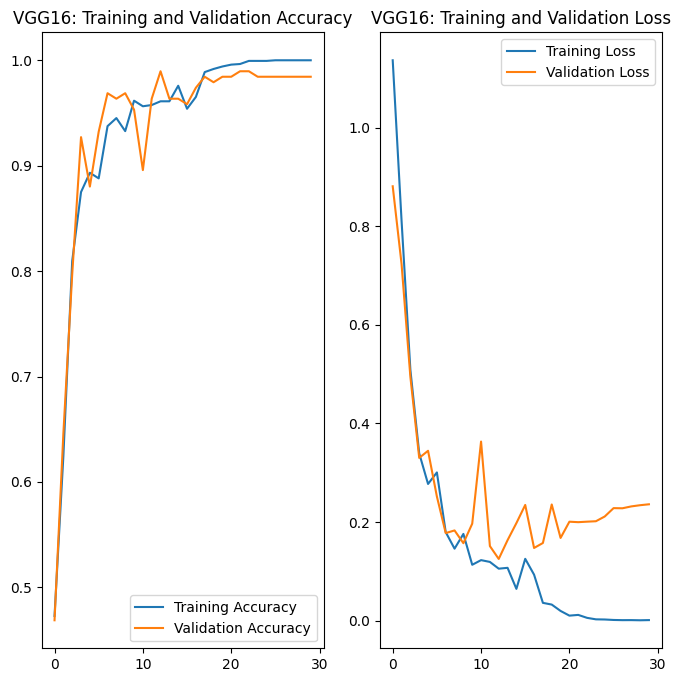

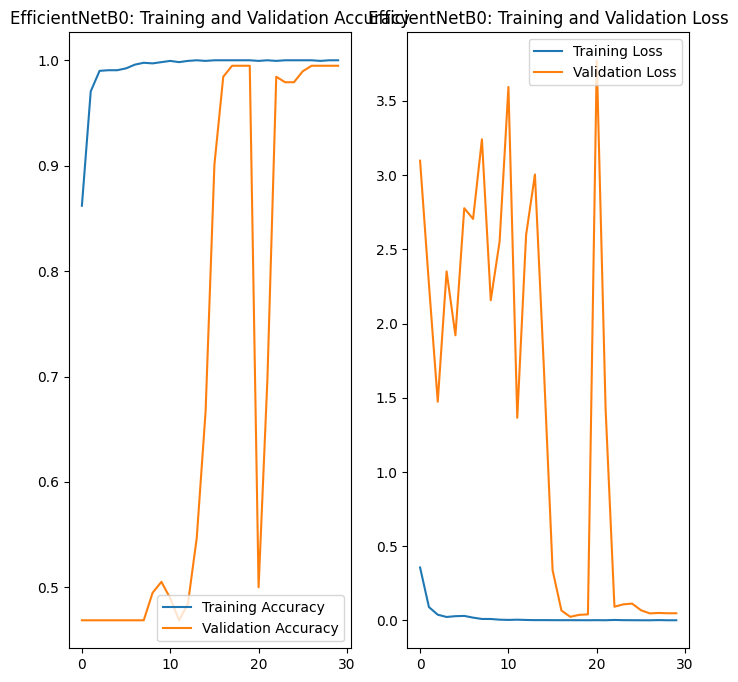

In [29]:
for model_name, history in history_dict.items():
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(range(len(acc)), acc, label='Training Accuracy')
    plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{model_name}: Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(range(len(loss)), loss, label='Training Loss')
    plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'{model_name}: Training and Validation Loss')

    plt.show()


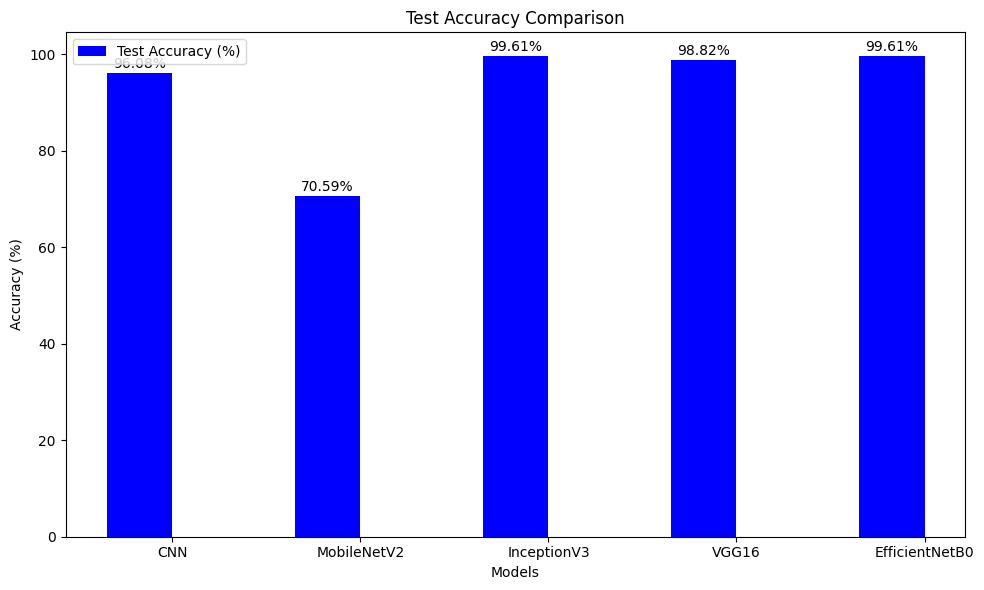

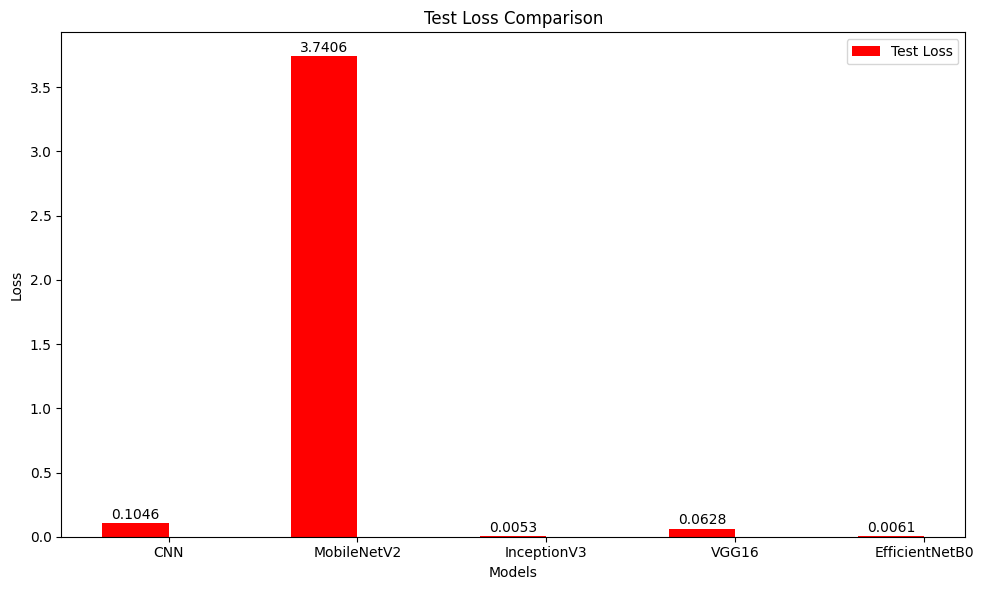

In [31]:
models = list(test_results.keys())
test_accuracy = [score[1] * 100 for score in test_results.values()]  # Accuracy in percentage
test_loss = [score[0] for score in test_results.values()]

x = np.arange(len(models))  
width = 0.35 

# Accuracy Bar Graph
fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(x - width / 2, test_accuracy, width, label='Test Accuracy (%)', color='blue')
ax.set_xlabel('Models')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Test Accuracy Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Add accuracy value labels
for i, bar in enumerate(bar1):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2.0, height + 0.5, f'{test_accuracy[i]:.2f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Loss Bar Graph
fig, ax = plt.subplots(figsize=(10, 6))
bar2 = ax.bar(x - width / 2, test_loss, width, label='Test Loss', color='red')
ax.set_xlabel('Models')
ax.set_ylabel('Loss')
ax.set_title('Test Loss Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Add loss value labels
for i, bar in enumerate(bar2):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2.0, height + 0.01, f'{test_loss[i]:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()
